## COMPASS Results Visualization

Note: Since we use timestamp to name our results folder, you need to modify the `fdir` to the `err_log_path` defined in `run_ablation.sh`. And `err_logs_ablation_2024-04-17_17-25-33/` folder saves the logs to reproduce the figures in our paper.

In [1]:
# fdir = "../err_logs_ablation_2024-08-15_09-59-34/"
fdir = "../err_logs_ablation_2024-04-17_17-25-33/"

In [2]:
# conda env: python3
import os
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
pd.options.mode.copy_on_write = True
# plt.rcParams['font.family'] = ['serif']
# plt.rcParams['font.serif'] = ['Times New Roman']
font = { 'size'   : 18}
plt.rc('font', **font)
color_bar1 = ["#7CBD3D", "#33B7FF", "#FF6F66", "#E3A735", "#E96A66", "#457B9D", "#66AB9E"]
color_bar2 = ["#2a9d8f", "#F6BD60", "#457b9d", "#F07167", "#BFA6A2", "#A1CD5A", "#ED7D31"]
hatches = ['//', 'xx', '..', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
# hatches = ['/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

In [3]:
areaKey_um2 = ["Chip Area", "Chip ADC.*?Area", "Chip IC Area", "Chip Accum.*?Area", "Chip Other.*?Area", "Chip Popcnt Area", "Chip Array Area"]
latKey_ns = ["Pipelined Clock Latency", "Total Read Latency", "Total Buffer Latency", "Total IC Latency", "Total Core Latency ADC", "Total Core Latency Accum", "Total Core Latency Other", "Total Array Read Latency", "Total Array Latency ADC", "Total Array Latency Accum", "Total Array Latency Other", "Total Read Latency Buffer", "Total Read Latency IC"]
engKey_pJ = ["Total Read Dynamic Energy", "Total Buffer Dynamic Energy", "Total IC Dynamic Energy", "Total Core Energy ADC", "Total Core Energy Accum", "Total Core Energy Other", "Total Core Energy Popcnt", "Total Leakage Energy", "Total Array Read Dynamic Energy", "Total Array Energy ADC", "Total Array Energy Accum", "Total Array Energy Other", "Total Array Energy Popcnt", "Total Read Dynamic Energy Buffer", "Total Read Dynamic Energy IC"]
perfKey = ["Energy Efficiency TOPS/W", "Throughput TOPS", "Throughput FPS", "Compute Efficiency TOPS/mm\^2"]

layer_latency_key= ["readLatency", "bufferLatency", "icLatency", "coreLatencyADC", "coreLatencyAccum", "coreLatencyOther"]
layer_energy_key= ["readDynamicEnergy", "bufferDynamicEnergy", "icDynamicEnergy", "coreEnergyADC", "coreEnergyAccum", "coreEnergyOther"]
layer_rate_key = ["successRate", "Sparsity", "Compression ratio"]

In [4]:
def extract_summary_info(fname, keys=areaKey_um2 + latKey_ns + engKey_pJ + perfKey):
    info_dict = {}
    with open(fname, 'r') as f:
        content = f.read()
        for key in keys:
            pat1 = re.compile(rf"{key}.*?(\d+\.\d+e\+\d+)")
            pat2 = re.compile(rf"{key}.*?(\d+\.\d+)")
            res1 = pat1.findall(content)
            res2 = pat2.findall(content)
            if len(res1):
                info_dict[key] = res1[0]
            elif len(res2):
                info_dict[key] = res2[0]
            else:
                # info_dict[key] = 0
                pass
                
    return info_dict

def extract_layer_perf(fname, keys=layer_latency_key + layer_energy_key + layer_rate_key):
    info_dict = defaultdict(dict)
    with open(fname, 'r') as f:
        content = f.read()
        for key in keys:
            pat1 = re.compile(rf"layer (\d+) {key}:.*?(\d+\.\d+e\+\d+)")
            pat2 = re.compile(rf"layer (\d+) {key}:.*?(\d+\.\d+)")
            pat3 = re.compile(rf"{re.escape(key)} of layer (\d+) .*?(\d+\.\d+)")
            res1 = pat1.findall(content)
            res2 = pat2.findall(content)
            res3 = pat3.findall(content)
            if len(res1):
                info_dict[key] = dict(res1)
            elif len(res2):
                info_dict[key] = dict(res2)
            elif len(res3):
                info_dict[key] = dict(res3)
            else:
                # info_dict.append('0')
                # print(f"Warning: {key} not found in {fname}")
                pass
    return info_dict

def dataLoader(fname='perf_summary.csv'):
    # Load the CSV file
    data = pd.read_csv(fname)
    data.sort_values(by="TW", ascending=True, inplace=True)

    data.head()
    data["Chip Area"] -= ((127 / 128) * data["Chip Popcnt Area"])
    data["Chip Other Area"] -= data["Chip Popcnt Area"]

    data.insert(9, 'Chip Buffer Area', data["Chip Other Area"] - data["Chip IC Area"])
    data["Chip Other Area"] -= data["Chip Buffer Area"]
    data["Core Latency Other"] -= data["Buffer Latency"]

    # if dataset is DVS128Gesture, then the TS=300
    data.insert(1, 'Timesteps', data['dataset'].map({'DVS128Gesture': 300, 'IMAGENET': 100, 'CIFAR10DVS': 100}))
    data.loc[data['dataset'] == 'DVS128Gesture', 'Compute Efficiency TOPS/mm^2'] /= (1e24 * 300 / data['TW'])
    data.loc[data['dataset'] == 'CIFAR10DVS', 'Compute Efficiency TOPS/mm^2'] /= (1e24 * 100 / data['TW'])
    data.loc[data['dataset'] == 'IMAGENET', 'Compute Efficiency TOPS/mm^2'] /= (1e24 * 100 / data['TW'])

    # mergedStep = math.ceil(Timesteps / TW)
    data.insert(4, 'mergedStep', np.ceil(data['Timesteps'] / data['TW']).astype(int))

    for col in data.columns:
        if 'latency' in col.lower():
            data[col] *= data['mergedStep']

    data.insert(14, 'Core Latency Array', data['mode'].map({'array': 2.038, 'column': 1.92}))

    data.rename(columns={'Chip ADC Area': 'ADC Area'}, inplace=True)
    data.rename(columns={'Chip Accum Area': 'Accum Area'}, inplace=True)
    data.rename(columns={'Chip Other Area': 'Other Area'}, inplace=True)
    data.rename(columns={'Chip Popcnt Area': 'Popcnt Area'}, inplace=True)
    data.rename(columns={'Chip Array Area': 'Array Area'}, inplace=True)
    data.rename(columns={'Chip Buffer Area': 'Buffer Area'}, inplace=True)
 
    data.rename(columns={'Core Latency Array': 'Array Latency'}, inplace=True)
    data.rename(columns={'Core Latency ADC': 'ADC Latency'}, inplace=True)
    data.rename(columns={'Core Latency Accum': 'Accum Latency'}, inplace=True)
    data.rename(columns={'Core Latency Other': 'Other Latency'}, inplace=True)

    data.rename(columns={'Total Buffer Dynamic Energy': 'Buffer Energy'}, inplace=True)
    data.rename(columns={'Total IC Dynamic Energy': 'IC Energy'}, inplace=True)
    data.rename(columns={'Total Core Energy ADC': 'ADC Energy'}, inplace=True)
    data.rename(columns={'Total Core Energy Accum': 'Accum Energy'}, inplace=True)
    data.rename(columns={'Total Core Energy Other': 'Other Energy'}, inplace=True)
    data.rename(columns={'Total Core Energy Popcnt': 'Popcnt Energy'}, inplace=True)
 

    # 检查是否所有的数据都是有效的，如果存在未运行成功的数据，那么Energy Efficiency TOPS/W应该为0
    for index, row in data.iterrows():
        # assert row["Energy Efficiency TOPS/W"] != 0, f"{row['dataset']}-{row['mode']}-{row['TW']} miss"
        if row["Energy Efficiency TOPS/W"] == 0:
            print(f"{row['dataset']}-{row['mode']}-{row['TW']} miss")
    
    # if not os.path.exists('../perf_summary_modify.csv'):
    # 	data.to_csv('../perf_summary_modify.csv', index=False)


    # Display the first few rows of the dataframe to understand its structure
    return data

In [5]:
import platform

summary_fname = "./perf_summary.csv"
# if not os.path.exists(summary_fname):
if True:
    with open(summary_fname, 'w') as fw:
        all_keys = areaKey_um2 + latKey_ns + engKey_pJ + perfKey
        if platform.system() == 'Windows':
            fw.write('dataset,mode,TW,dyn_stw,speculative,csr_compress,' + ','.join(all_keys).replace(".*?", " ", -1).replace('\\', '', -1) + '\n')
        elif platform.system() == 'Linux':
            fw.write('dataset,mode,TW,dyn_stw,speculative,csr_compress,' + ','.join(all_keys).replace(".*?", " ", -1).replace('//', '/', -1) + '\n')
        for fname in os.listdir(fdir):
            # extract_layer_info(fname)
            if fname.split('.')[-1] != "err":
                continue
            TW, dataset, mode, dyn_stw, spec, csr = re.split(r"_|\.", fname)[1:7]
            info_dict = extract_summary_info(os.path.join(fdir, fname))
            fw.write(f'{dataset},{mode},{TW},{dyn_stw},{spec},{csr}')
            # + ','.join(info_dict) + '\n')
            for key in all_keys:
                if key in info_dict:
                    fw.write(',' + str(info_dict[key]))
                else:
                    # fw.write(',')
                    # print(f"Warning: {key} not found in {fname}")
                    raise ValueError(f"{key} not found in {fname}")
            fw.write('\n')

In [6]:
summary_fname = "./perf_summary.csv"
pd.set_option('display.max_columns', 85)
df = pd.read_csv(summary_fname)
df.sort_values(by=["dyn_stw", "mode", "TW"], ascending=True, inplace=True)
df['dyn_stw'] = df['dyn_stw'].astype(str)
df['speculative'] = df['speculative'].astype(str)
df['csr_compress'] = df['csr_compress'].astype(str)
df['TW'] = df['TW'].astype(str)
df['series'] = df['mode'].str.lower() + '_' + df['TW'] + "_" + df['dyn_stw'].str.lower()

# 将DVS128Gesture的数据替换为DVS128GestureSimplify
filt = (df['dataset'] == 'DVS128Gesture') 
pd.set_option('display.max_rows', 85)
df = df.loc[~filt]
df['dataset'].replace({'DVS128GestureSimplify': 'DVS128Gesture'}, inplace=True)


In [7]:
# FIXME: 在不进行消融实验时，暂时直接过滤掉消融实验的数据（为了偷懒不改代码。。。）
filt_ablation = ((df['dyn_stw'] == 'True') & ((df['speculative'] == 'False') | (df['csr_compress'] == 'False')))
df = df.loc[~filt_ablation]

In [8]:
max_TOPS_per_W = df.loc[(df['dyn_stw']=='True')]['Energy Efficiency TOPS/W'].max()
max_TOPS = df.loc[(df['dyn_stw']=='True')]['Throughput TOPS'].max()
max_Area_Efficiency = df.loc[(df['dyn_stw']=='True')]['Compute Efficiency TOPS/mm\^2'].max()
print(f"{max_TOPS_per_W=}, {max_TOPS=}, {max_Area_Efficiency=}")

max_TOPS_per_W=180.5348982507703, max_TOPS=22.97856515942555, max_Area_Efficiency=0.3841167073988619


In [9]:
series_grp = df.groupby('series')
sorted_series = sorted(df['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])

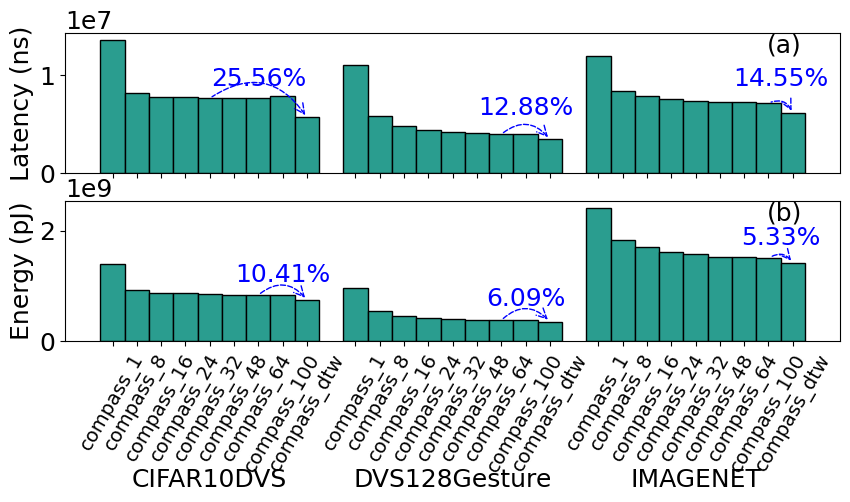

In [10]:
df_sche = df.loc[df['mode'] == 'ComPASS']
sorted_series = sorted(df_sche['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
# disp_keys = ['Total Read Latency Buffer', 'Total Read Latency IC', 'Total Core Latency Other', 'Total Array Latency ADC', 'Total Array Latency Accum']
disp_keys = ['Total Array Latency ADC', 'Total Array Latency Accum']
df_sche['Array Latency'] = df_sche['Total Array Latency ADC'] + df_sche['Total Array Latency Accum']
disp_keys = ['Array Latency']
series_grp = df_sche.groupby('series')
# disp_keys = ['Total Core Latency ADC', 'Total Core Latency Accum', 'Total Core Latency Other']

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))
bar_width = 0.1
index = np.arange(len(df_sche['dataset'].unique()))
mode_indexes = []

unique_mode = df_sche['series'].apply(lambda x: x.split('_')[0]).unique().tolist()

ckpt_top = []
lns = []
for idx, series in enumerate(sorted_series):
    # print(f"{series=}")
    unique_mode_idx = unique_mode.index(series.split('_')[0])
    res = series_grp.get_group(series).sort_values(by=['dataset'])
    # print(res['dataset'])
    bottom = np.zeros(len(df_sche['dataset'].unique()))
    for idk, disp_key in enumerate(disp_keys):
        if idx == 0:
            bar_chart = ax1.bar(index + (idx - (math.floor(len(df_sche['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, label=disp_key, color=color_bar2[idk], edgecolor='black')
            
        else:
            bar_chart = ax1.bar(index + (idx - (math.floor(len(df_sche['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, color=color_bar2[idk], edgecolor='black')

        bottom += res[disp_key]
        if idk == 0:
            mode_indexes.append(index + (idx - (math.floor(len(df_sche['dataset'].unique())))/2)*bar_width)
    ckpt_top.append(bottom)

sorted_series = [item.replace("_false", "") for item in sorted_series]
sorted_series = [item.replace("_0", "") for item in sorted_series]
sorted_series = [item.replace("_true", "_dtw") for item in sorted_series]
# ax1.xticks(list(np.array(mode_indexes).T.flatten()), sorted_series * len(df_sche['dataset'].unique()), rotation=90, fontsize=14)
# plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.50, 1.13),
#                  fancybox=True, shadow=True, ncol=3, labelspacing=0.4, handleheight=1.2, columnspacing=0.4)

# plt.legend(labels=['Buffer', 'IC', 'Other', 'Array', 'Calculation'], fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
#            fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)
# plt.legend(labels=['Array', 'Calculation'], fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
#            fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)

ckpt_top = np.array(ckpt_top)
static_ckpt_top = ckpt_top[:-1, :]
dyn_ckpt_top = ckpt_top[-1, :]
# find the minimum value and index for each static checkpoint dataset
min_static_ckpt = np.min(static_ckpt_top, axis=0)
min_static_ckpt_idx = np.argmin(static_ckpt_top, axis=0)
speedup = (min_static_ckpt - dyn_ckpt_top) / min_static_ckpt
dataset_names = sorted(df_sche['dataset'].unique())
for i, dataset_name in enumerate(dataset_names):
    start_xloc = mode_indexes[0][i] + bar_width * min_static_ckpt_idx[i]
    end_xloc = mode_indexes[-1][i]
    start_yloc = min_static_ckpt[i]
    end_yloc = dyn_ckpt_top[i]
    # plt.annotate("", xy=(end_xloc, end_yloc), xytext=(start_xloc, start_yloc), arrowprops=dict(arrowstyle="->", color='black'))
    ax1.annotate("", xy=(start_xloc, start_yloc), xytext=(end_xloc, end_yloc), color="#a30b33",
                arrowprops=dict(
        color="blue",
        arrowstyle="<-",
        connectionstyle="arc3,rad=0.5",
        linestyle="--",
        # linewidth=1
    ),
    )
    ax1.annotate(f"{speedup[i]*100:.2f}%", (start_xloc + (end_xloc - start_xloc) / 2, start_yloc + (end_yloc - start_yloc) / 2), textcoords="offset points", xytext=(0, 16), ha='center', color="blue")

for i, dataset_name in enumerate(dataset_names):
    ax1.annotate(dataset_name, (index[i] + 0.25, 0), textcoords="offset points", xytext=(0, -105), ha='center')
# plt.ylabel(disp_key)
# plt.yscale('log')
# plt.legend()
ax1.set_ylabel('Latency (ns)')
# plt.savefig('export/dyn_lat_comp.pdf', bbox_inches='tight')
ax1.annotate("(a)", (2.6, 1), textcoords="offset points", xytext=(2.6, 87), ha='center')

## ax2 plot
sorted_series = sorted(df_sche['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
# disp_keys = ['Total Read Dynamic Energy Buffer', 'Total Read Dynamic Energy IC', 'Total Core Energy Other', 'Total Array Energy ADC', 'Total Array Energy Accum', 'Total Array Energy Popcnt']
disp_keys = ['Total Array Energy ADC', 'Total Array Energy Accum', 'Total Array Energy Popcnt']
df_sche['Array Energy'] = df_sche['Total Array Energy ADC'] + df_sche['Total Array Energy Accum'] + df_sche['Total Array Energy Popcnt']
disp_keys = ['Array Energy']
series_grp = df_sche.groupby('series')

bar_width = 0.1
index = np.arange(len(df_sche['dataset'].unique()))
mode_indexes = []

unique_mode = df_sche['series'].apply(lambda x: x.split('_')[0]).unique().tolist()

ckpt_top = []
lns = []
for idx, series in enumerate(sorted_series):
    # print(f"{series=}")
    unique_mode_idx = unique_mode.index(series.split('_')[0])
    res = series_grp.get_group(series).sort_values(by=['dataset'])
    # print(res['dataset'])
    bottom = np.zeros(len(df_sche['dataset'].unique()))
    for idk, disp_key in enumerate(disp_keys):
        if idx == 0:
            bar_chart = ax2.bar(index + (idx - (math.floor(len(df_sche['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, label=disp_key, color=color_bar2[idk], edgecolor='black')
            
        else:
            bar_chart = ax2.bar(index + (idx - (math.floor(len(df_sche['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, color=color_bar2[idk], edgecolor='black')

        bottom += res[disp_key]
        if idk == 0:
            mode_indexes.append(index + (idx - (math.floor(len(df_sche['dataset'].unique())))/2)*bar_width)
    ckpt_top.append(bottom)

sorted_series = [item.replace("_false", "") for item in sorted_series]
sorted_series = [item.replace("_0", "") for item in sorted_series]
sorted_series = [item.replace("_true", "_dtw") for item in sorted_series]
ax2.set_xticks(list(np.array(mode_indexes).T.flatten()), sorted_series * len(df_sche['dataset'].unique()), rotation=60, fontsize=14)
# plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.50, 1.13),
#                  fancybox=True, shadow=True, ncol=4, labelspacing=0.4, handleheight=1.5)
# plt.legend(labels=['Buffer', 'IC', 'Other', 'Array', 'Calculation'], fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
#            fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)
# plt.legend(labels=['Array', 'Calculation'], fontsize=12, loc='upper center', bbox_to_anchor=(0.2, 1.0),
#            fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)

ckpt_top = np.array(ckpt_top)
static_ckpt_top = ckpt_top[:-1, :]
dyn_ckpt_top = ckpt_top[-1, :]
# find the minimum value and index for each static checkpoint dataset
min_static_ckpt = np.min(static_ckpt_top, axis=0)
min_static_ckpt_idx = np.argmin(static_ckpt_top, axis=0)
speedup = (min_static_ckpt - dyn_ckpt_top) / min_static_ckpt
dataset_names = sorted(df_sche['dataset'].unique())
for i, dataset_name in enumerate(dataset_names):
    start_xloc = mode_indexes[0][i] + bar_width * min_static_ckpt_idx[i]
    end_xloc = mode_indexes[-1][i]
    start_yloc = min_static_ckpt[i]
    end_yloc = dyn_ckpt_top[i]
    # plt.annotate("", xy=(end_xloc, end_yloc), xytext=(start_xloc, start_yloc), arrowprops=dict(arrowstyle="->", color='black'))
    ax2.annotate("", xy=(start_xloc, start_yloc), xytext=(end_xloc, end_yloc), color="#a30b33",
                arrowprops=dict(
        color="blue",
        arrowstyle="<-",
        connectionstyle="arc3,rad=0.5",
        linestyle="--",
        # linewidth=1
    ),
    )
    ax2.annotate(f"{speedup[i]*100:.2f}%", (start_xloc + (end_xloc - start_xloc) / 2, start_yloc + (end_yloc - start_yloc) / 2), textcoords="offset points", xytext=(0, 11), ha='center', color="blue")

for i, dataset_name in enumerate(dataset_names):
    ax2.annotate(dataset_name, (index[i] + 0.25, 0), textcoords="offset points", xytext=(0, -105), ha='center')

ax2.annotate("(b)", (2.6, 1), textcoords="offset points", xytext=(2.6, 87), ha='center')

ax2.set_ylabel('Energy (pJ)')
plt.savefig('export/dyn_comp.pdf', bbox_inches='tight')

In [11]:
filt = (df['series'] == 'ptb_16_false') | (df['series'] == 'strawman_0_false') | (df['series'] == 'compass_0_true')
df_fig1 = df.loc[filt]
series_grp = df_fig1.groupby('series')
sorted_series = sorted(df_fig1['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
sorted_series

['ptb_16_false', 'strawman_0_false', 'compass_0_true']

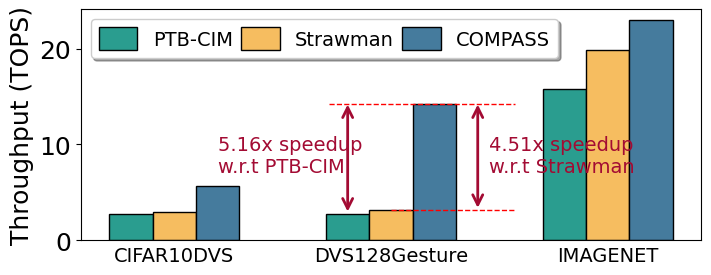

In [12]:
local_df = df_fig1
sorted_series = sorted(local_df['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
disp_keys = ['Throughput TOPS']

fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.2
index = np.arange(len(local_df['dataset'].unique()))
mode_indexes = []

unique_mode = local_df['series'].apply(lambda x: x.split('_')[0]).unique().tolist()

lns = []
for idx, series in enumerate(sorted_series):
    # print(f"{series=}")
    unique_mode_idx = unique_mode.index(series.split('_')[0])
    res = series_grp.get_group(series).sort_values(by=['dataset'])
    # print(res['dataset'])
    bottom = np.zeros(len(local_df['dataset'].unique()))
    for idk, disp_key in enumerate(disp_keys):
        if idk == 0:
            bar_chart = plt.bar(index + (idx - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, label=series.split('_')[0], color=color_bar2[idx], edgecolor='black')
            
        else:
            bar_chart = plt.bar(index + (idx - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, color=color_bar2[idx], edgecolor='black')

        bottom += res[disp_key]
        if idk == 0:
            mode_indexes.append(index + (idx - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width)

sorted_series = [item.split('_')[0] for item in sorted_series]
sorted_series = ['PTB-CIM' if item == 'ptb' else item for item in sorted_series]
sorted_series = ['Strawman' if item == 'strawman' else item for item in sorted_series]
sorted_series = ['COMPASS' if item == 'compass' else item for item in sorted_series]
# plt.xticks(list(np.array(mode_indexes).T.flatten()), sorted_series * len(local_df['dataset'].unique()), rotation=45, fontsize=14)
# hide xticks
plt.xticks([])
plt.legend(["PTB-CIM", "Strawman", "COMPASS"], fontsize=14, loc='upper left', bbox_to_anchor=(0.0, 1.0),
                 fancybox=True, shadow=True, ncol=3, labelspacing=0.4, handleheight=1.5, columnspacing=0.4)
                
# xloc = len(local_df['dataset'].unique()) + (len(disp_keys) - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width
yloc1 = local_df.loc[(df['dataset'] == 'DVS128Gesture') & (df['series'] == 'compass_0_true')]['Throughput TOPS'].values[0]
yloc2 = local_df.loc[(df['dataset'] == 'DVS128Gesture') & (df['series'] == 'strawman_0_false')]['Throughput TOPS'].values[0]
yloc3 = local_df.loc[(df['dataset'] == 'DVS128Gesture') & (df['series'] == 'ptb_16_false')]['Throughput TOPS'].values[0]
plt.axhline(y=yloc1, xmin=0.4, xmax=0.7, color='r', linestyle='--', linewidth=1)
plt.axhline(y=yloc2, xmin=0.5, xmax=0.7, color='r', linestyle='--', linewidth=1)
plt.annotate("", xy=(1.3, 1.02*yloc1), xytext=(1.3, 0.98*yloc2), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
plt.annotate(f"{yloc1/yloc2:.2f}x speedup\nw.r.t Strawman", xy=(1.35, yloc1), xytext=(1.35, 0.5*yloc1), color="#a30b33", fontsize=14)
plt.axhline(y=yloc3, xmin=0.4, xmax=0.4, color='r', linestyle='--', linewidth=1)
plt.annotate("", xy=(0.7, 1.02*yloc1), xytext=(0.7, 0.98*yloc3), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
plt.annotate(f"{yloc1/yloc3:.2f}x speedup\nw.r.t PTB-CIM", xy=(0.1, yloc1), xytext=(0.1, 0.5*yloc1), color="#a30b33", fontsize=14)

dataset_names = sorted(local_df['dataset'].unique())
for i, dataset_name in enumerate(dataset_names):
    plt.annotate(dataset_name, (index[i] - 0.1, 0), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=14)

plt.ylabel("Throughput (TOPS)")
plt.savefig('export/tp.pdf', bbox_inches='tight')

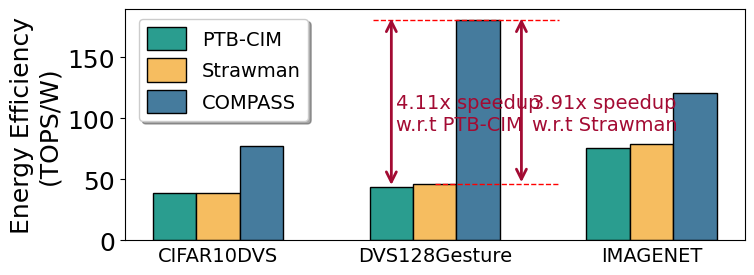

In [13]:
local_df = df_fig1
sorted_series = sorted(local_df['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
disp_keys = ['Energy Efficiency TOPS/W']

fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.2
index = np.arange(len(local_df['dataset'].unique()))
mode_indexes = []

unique_mode = local_df['series'].apply(lambda x: x.split('_')[0]).unique().tolist()

lns = []
for idx, series in enumerate(sorted_series):
    # print(f"{series=}")
    unique_mode_idx = unique_mode.index(series.split('_')[0])
    res = series_grp.get_group(series).sort_values(by=['dataset'])
    # print(res['dataset'])
    bottom = np.zeros(len(local_df['dataset'].unique()))
    for idk, disp_key in enumerate(disp_keys):
        if idk == 0:
            bar_chart = plt.bar(index + (idx - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, label=series.split('_')[0], color=color_bar2[idx], edgecolor='black')
            
        else:
            bar_chart = plt.bar(index + (idx - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, color=color_bar2[idx], edgecolor='black')

        bottom += res[disp_key]
        if idk == 0:
            mode_indexes.append(index + (idx - (math.floor(len(local_df['dataset'].unique())))/2)*bar_width)

sorted_series = [item.split('_')[0] for item in sorted_series]
sorted_series = ['PTB-CIM' if item == 'ptb' else item for item in sorted_series]
sorted_series = ['Strawman' if item == 'strawman' else item for item in sorted_series]
sorted_series = ['COMPASS' if item == 'compass' else item for item in sorted_series]
# plt.xticks(list(np.array(mode_indexes).T.flatten()), sorted_series * len(local_df['dataset'].unique()), rotation=45, fontsize=14)
# hide xticks
plt.xticks([])
plt.legend(["PTB-CIM", "Strawman", "COMPASS"], fontsize=14, loc='upper center', bbox_to_anchor=(0.16, 1.0),
                 fancybox=True, shadow=True, labelspacing=0.4, handleheight=1.5, columnspacing=0.4)

yloc1 = local_df.loc[(df['dataset'] == 'DVS128Gesture') & (df['series'] == 'compass_0_true')][disp_keys[0]].values[0]
yloc2 = local_df.loc[(df['dataset'] == 'DVS128Gesture') & (df['series'] == 'strawman_0_false')][disp_keys[0]].values[0]
yloc3 = local_df.loc[(df['dataset'] == 'DVS128Gesture') & (df['series'] == 'ptb_16_false')][disp_keys[0]].values[0]
plt.axhline(y=yloc1, xmin=0.4, xmax=0.7, color='r', linestyle='--', linewidth=1)
plt.axhline(y=yloc2, xmin=0.5, xmax=0.7, color='r', linestyle='--', linewidth=1)
plt.annotate("", xy=(1.3, 1.02*yloc1), xytext=(1.3, 0.98*yloc2), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
plt.annotate(f"{yloc1/yloc2:.2f}x speedup\nw.r.t Strawman", xy=(1.35, yloc1), xytext=(1.35, 0.5*yloc1), color="#a30b33", fontsize=14)
plt.axhline(y=yloc3, xmin=0.4, xmax=0.4, color='r', linestyle='--', linewidth=1)
plt.annotate("", xy=(0.7, 1.02*yloc1), xytext=(0.7, 0.98*yloc3), color="#a30b33", arrowprops=dict(arrowstyle="<->", color="#a30b33", linewidth=2))
plt.annotate(f"{yloc1/yloc3:.2f}x speedup\nw.r.t PTB-CIM", xy=(0.72, yloc1), xytext=(0.72, 0.5*yloc1), color="#a30b33", fontsize=14)

dataset_names = sorted(local_df['dataset'].unique())
for i, dataset_name in enumerate(dataset_names):
    plt.annotate(dataset_name, (index[i] - 0.1, 0), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=14)

plt.ylabel("Energy Efficiency\n(TOPS/W)")
plt.savefig('export/ee.pdf', bbox_inches='tight')

In [14]:
df_fig1_strawman = df.loc[df['mode']=='Strawman']
print(df_fig1_strawman['Total Array Latency ADC'] / df_fig1_strawman['Total Read Latency'])
print(df_fig1_strawman['Total Read Latency Buffer'] / df_fig1_strawman['Total Read Latency'])
print(df_fig1_strawman['Total Core Energy ADC'] / df_fig1_strawman['Total Read Dynamic Energy'])
print(df_fig1_strawman['Total Array Energy Accum'] / df_fig1_strawman['Total Read Dynamic Energy'])

38    0.072069
44    0.084567
54    0.029750
dtype: float64
38    0.747036
44    0.711418
54    0.905000
dtype: float64
38    0.106306
44    0.108176
54    0.108000
dtype: float64
38    0.863063
44    0.874214
54    0.876364
dtype: float64


In [15]:
print("ComPASS Buffer Latency / Strawman Buffer Latency")
print(df_fig1.loc[(df_fig1['mode']=='ComPASS') & (df_fig1['dataset']=='DVS128Gesture')]['Total Read Latency Buffer'].values[0] / df_fig1.loc[(df_fig1['mode']=='Strawman') & (df_fig1['dataset']=='DVS128Gesture')]['Total Read Latency Buffer'].values[0])
print("ComPASS Accum Latency / Strawman Accum Latency")
print(df_fig1.loc[(df_fig1['mode']=='ComPASS') & (df_fig1['dataset']=='DVS128Gesture')]['Total Array Latency Accum'].values[0] / df_fig1.loc[(df_fig1['mode']=='Strawman') & (df_fig1['dataset']=='DVS128Gesture')]['Total Array Latency Accum'].values[0])

print("ComPASS Buffer Energy / Strawman Buffer Energy")
print(df_fig1.loc[(df_fig1['mode']=='ComPASS') & (df_fig1['dataset']=='DVS128Gesture')]['Total Read Dynamic Energy Buffer'].values[0] / df_fig1.loc[(df_fig1['mode']=='Strawman') & (df_fig1['dataset']=='DVS128Gesture')]['Total Read Dynamic Energy Buffer'].values[0])
print("ComPASS Accum Latency / Strawman Accum Latency")
print(df_fig1.loc[(df_fig1['mode']=='ComPASS') & (df_fig1['dataset']=='DVS128Gesture')]['Total Array Energy Accum'].values[0] / df_fig1.loc[(df_fig1['mode']=='Strawman') & (df_fig1['dataset']=='DVS128Gesture')]['Total Array Energy Accum'].values[0])



ComPASS Buffer Latency / Strawman Buffer Latency
0.19576719576719576
ComPASS Accum Latency / Strawman Accum Latency
0.30825688073394497
ComPASS Buffer Energy / Strawman Buffer Energy
0.40108695652173915
ComPASS Accum Latency / Strawman Accum Latency
0.3569937369519833


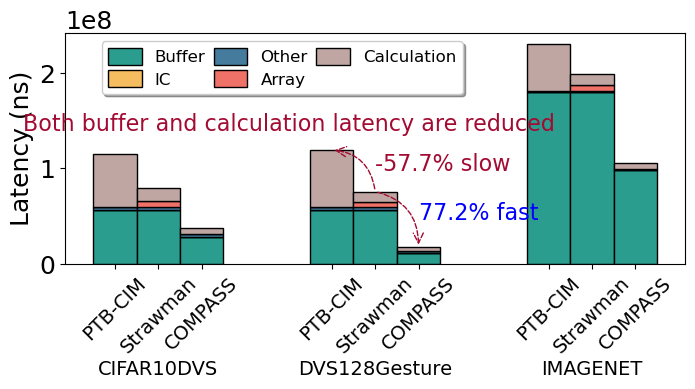

In [16]:
disp_keys = ['Total Buffer Latency', 'Total IC Latency', 'Total Core Latency Other',
             'Total Array Latency ADC', 'Total Array Latency Accum']
local_df = df_fig1
sorted_series = sorted(df_fig1['series'].unique(), key=lambda x: [
                       x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
# disp_keys = ['Total Read Dynamic Energy Buffer', 'Total Read Dynamic Energy IC', 'Total Core Energy Other', 'Total Array Energy ADC', 'Total Array Energy Accum', 'Total Array Energy Popcnt']

fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.2
index = np.arange(len(df_fig1['dataset'].unique()))
mode_indexes = []

unique_mode = df_fig1['series'].apply(
    lambda x: x.split('_')[0]).unique().tolist()

ckpt_top = defaultdict(list)
lns = []
for idx, series in enumerate(sorted_series):
    # print(f"{series=}")
    unique_mode_idx = unique_mode.index(series.split('_')[0])
    res = series_grp.get_group(series).sort_values(by=['dataset'])
    # print(res['dataset'])
    bottom = np.zeros(len(df_fig1['dataset'].unique()))
    for idk, disp_key in enumerate(disp_keys):
        if idx == 0:
            lns.append(plt.bar(index + (idx - (math.floor(len(df_fig1['dataset'].unique())))/2)*bar_width,
                       height=res[disp_key], width=bar_width, bottom=bottom, label=disp_key, color=color_bar2[idk], edgecolor='black'))

        else:
            bar_chart = plt.bar(index + (idx - (math.floor(len(df_fig1['dataset'].unique())))/2)*bar_width,
                                height=res[disp_key], width=bar_width, bottom=bottom, color=color_bar2[idk], edgecolor='black')

        bottom += res[disp_key]
        if idk == 0:
            mode_indexes.append(
                index + (idx - (math.floor(len(df_fig1['dataset'].unique())))/2)*bar_width)
    ckpt_top[idx] = bottom.tolist()

sorted_series = [item.split('_')[0] for item in sorted_series]
sorted_series = ['PTB-CIM' if item ==
                 'ptb' else item for item in sorted_series]
sorted_series = ['Strawman' if item ==
                 'strawman' else item for item in sorted_series]
sorted_series = ['COMPASS' if item ==
                 'compass' else item for item in sorted_series]

plt.xticks(list(np.array(mode_indexes).T.flatten()), sorted_series *
           len(df_fig1['dataset'].unique()), rotation=45, fontsize=14)

# override legend
labs = [l.get_label() for l in lns]
# print(labs)
plt.legend(labels=['Buffer', 'IC', 'Other', 'Array', 'Calculation'], fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
           fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)
# plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
#                  fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)

dataset_names = sorted(df_fig1['dataset'].unique())
for i, dataset_name in enumerate(dataset_names):
    plt.annotate(dataset_name, (index[i] - 0.1, 0),
                 textcoords="offset points", xytext=(0, -80), ha='center', fontsize=14)

plt.annotate("Both buffer and calculation latency are reduced", (0.5, 0.8),
             textcoords="offset points", xytext=(0.5, 96), ha='center', color="#a30b33", fontsize=16)

plt.annotate("", xy=(index[1]-bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]-0.1, ckpt_top[1][1]), color="#a30b33",
             arrowprops=dict(
    color="#a30b33",
    arrowstyle="->",
    connectionstyle="arc3,rad=0.4",
    linestyle="--",
    # linewidth=1
),
)
plt.annotate(f"{(ckpt_top[1][1]-ckpt_top[0][1])/ckpt_top[1][1]*100:.1f}% slow", xy=(index[1]-bar_width+0.1, (ckpt_top[0][1]+ckpt_top[1][1])/2), xytext=(index[1]-bar_width+0.1, (ckpt_top[0][1]+ckpt_top[1][1])/2), color="#a30b33", fontsize=16)

plt.annotate("", xy=(index[1]-0.1, ckpt_top[1][1]), xytext=(index[1]+bar_width-0.1, ckpt_top[2][1]), color="#a30b33",
             arrowprops=dict(
    color="#a30b33",
    arrowstyle="<-",
    connectionstyle="arc3,rad=0.4",
    linestyle="--",
    # linewidth=1
),
)
plt.annotate(f"{(ckpt_top[1][1]-ckpt_top[2][1])/ckpt_top[1][1]*100:.1f}% fast", xy=(index[1]-bar_width+0.1, (ckpt_top[2][1]+ckpt_top[1][1])/2), xytext=(index[1]+bar_width-0.1, (ckpt_top[2][1]+ckpt_top[1][1])/2), color="blue", fontsize=16)

plt.ylabel('Latency (ns)')
plt.savefig('export/latency_brk.pdf', bbox_inches='tight')

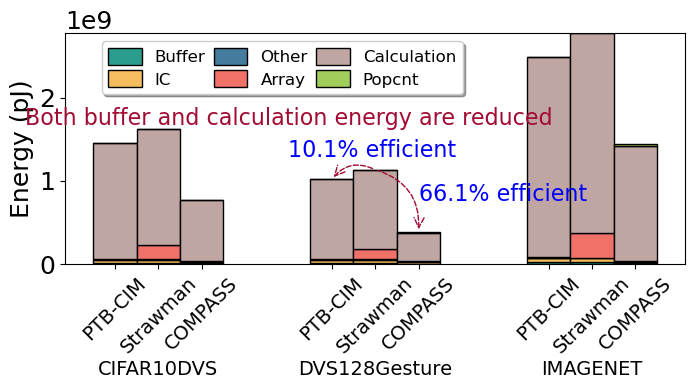

In [17]:
local_df = df_fig1
sorted_series = sorted(df_fig1['series'].unique(), key=lambda x: [x.split('_')[2], x.split('_')[0], int(x.split('_')[1])])
disp_keys = ['Total Read Dynamic Energy Buffer', 'Total Read Dynamic Energy IC', 'Total Core Energy Other', 'Total Array Energy ADC', 'Total Array Energy Accum', 'Total Array Energy Popcnt']

fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.2
index = np.arange(len(df_fig1['dataset'].unique()))
mode_indexes = []

unique_mode = df_fig1['series'].apply(lambda x: x.split('_')[0]).unique().tolist()

ckpt_top = defaultdict(list)
lns = []
for idx, series in enumerate(sorted_series):
    # print(f"{series=}")
    unique_mode_idx = unique_mode.index(series.split('_')[0])
    res = series_grp.get_group(series).sort_values(by=['dataset'])
    # print(res['dataset'])
    bottom = np.zeros(len(df_fig1['dataset'].unique()))
    for idk, disp_key in enumerate(disp_keys):
        if idx == 0:
            bar_chart = plt.bar(index + (idx - (math.floor(len(df_fig1['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, label=disp_key, color=color_bar2[idk], edgecolor='black')
            
        else:
            bar_chart = plt.bar(index + (idx - (math.floor(len(df_fig1['dataset'].unique())))/2)*bar_width, height=res[disp_key], width=bar_width, bottom=bottom, color=color_bar2[idk], edgecolor='black')

        bottom += res[disp_key]
        if idk == 0:
            mode_indexes.append(index + (idx - (math.floor(len(df_fig1['dataset'].unique())))/2)*bar_width)
    ckpt_top[idx] = bottom.tolist()

sorted_series = [item.split('_')[0] for item in sorted_series]
sorted_series = ['PTB-CIM' if item == 'ptb' else item for item in sorted_series]
sorted_series = ['Strawman' if item == 'strawman' else item for item in sorted_series]
sorted_series = ['COMPASS' if item == 'compass' else item for item in sorted_series]

plt.xticks(list(np.array(mode_indexes).T.flatten()), sorted_series * len(df_fig1['dataset'].unique()), rotation=45, fontsize=14)
plt.legend(labels=['Buffer', 'IC', 'Other', 'Array', 'Calculation', 'Popcnt'], fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
                 fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)
# plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.35, 1.0),
#                  fancybox=True, shadow=True, ncol=3, labelspacing=0.3, handleheight=1.2, columnspacing=0.5)

dataset_names = sorted(df_fig1['dataset'].unique())
for i, dataset_name in enumerate(dataset_names):
    plt.annotate(dataset_name, (index[i] - 0.1, 0), textcoords="offset points", xytext=(0, -80), ha='center', fontsize=14)

plt.annotate("Both buffer and calculation energy are reduced", (0.5, 0.8), textcoords="offset points", xytext=(0.5, 100), ha='center', color="#a30b33", fontsize=16)

plt.annotate("", xy=(index[1]-bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]-0.1, ckpt_top[1][1]), color="#a30b33",
             arrowprops=dict(
    color="#a30b33",
    arrowstyle="->",
    connectionstyle="arc3,rad=0.4",
    linestyle="--",
    # linewidth=1
),
)
plt.annotate(f"{(ckpt_top[1][1]-ckpt_top[0][1])/ckpt_top[1][1]*100:.1f}% efficient", xy=(index[1]-bar_width+0.1, (ckpt_top[0][1]+ckpt_top[1][1])/2), xytext=(index[1]-bar_width-0.3, 1.2*(ckpt_top[0][1]+ckpt_top[1][1])/2), color="blue", fontsize=16)

plt.annotate("", xy=(index[1]-0.1, ckpt_top[1][1]), xytext=(index[1]+bar_width-0.1, ckpt_top[2][1]), color="#a30b33",
             arrowprops=dict(
    color="#a30b33",
    arrowstyle="<-",
    connectionstyle="arc3,rad=0.4",
    linestyle="--",
    # linewidth=1
),
)
plt.annotate(f"{(ckpt_top[1][1]-ckpt_top[2][1])/ckpt_top[1][1]*100:.1f}% efficient", xy=(index[1]-bar_width+0.1, (ckpt_top[2][1]+ckpt_top[1][1])/2), xytext=(index[1]+bar_width-0.1, (ckpt_top[2][1]+ckpt_top[1][1])/2), color="blue", fontsize=16)

plt.ylabel('Energy (pJ)')
plt.savefig('export/energy_brk.pdf', bbox_inches='tight')

In [18]:
# TODO: Area breakdown

## Layer-wise analysis

In [19]:
# fname = "PyNeuroSim_0_IMAGENET_ComPASS_True.err"
layer_summary_fname = "./layer_perf_summary.csv"
fname = os.path.join(fdir, fname)
print(fname)

../err_logs_ablation_2024-04-17_17-25-33/PyNeuroSim_1_DVS128GestureSimplify_PTB_False_False_False.err


In [20]:
all_keys = layer_latency_key + layer_energy_key + layer_rate_key

with open(layer_summary_fname, 'w') as fw:
    if platform.system() == 'Windows':
        fw.write('dataset,mode,TW,dyn_stw,speculative,csr_compress,layer,' + ','.join(all_keys).replace(".*?", " ", -1).replace('\\', '', -1) + '\n')
    elif platform.system() == 'Linux':
        # fw.write('layer,' + ','.join(all_keys).replace(".*?", " ", -1).replace('/', '', -1) + '\n')
        fw.write('dataset,mode,TW,dyn_stw,speculative,csr_compress,layer,' + ','.join(all_keys).replace(".*?", " ", -1).replace('//', '/', -1) + '\n')
    for fname in os.listdir(fdir):
        if fname.endswith('.err'):
            TW, dataset, mode, dyn_stw, speculative, csr_compress = re.split(r"_|\.", fname)[1:7]
            results = extract_layer_perf(os.path.join(fdir, fname))
            results = {layer: {key: results[key][layer] for key in results.keys()} for layer in results[list(results.keys())[0]].keys()}
            for layer in results.keys():
                fw.write(f"{dataset},{mode},{TW},{dyn_stw},{speculative},{csr_compress},{layer}")
                for key in all_keys:
                    if key in results[layer].keys():
                        fw.write(',' + str(results[layer][key]))
                    elif (key in layer_rate_key) and mode != 'compass' and dyn_stw == 'False' or speculative == 'False' or csr_compress == 'False':
                        fw.write(',0')
                    else:
                        print(f"{key=} {layer=} {mode=} {dyn_stw=} {speculative=} {csr_compress=}")
                        raise ValueError(f"Key {key} not found in {layer}")
                fw.write('\n')


In [21]:
layer_df = pd.read_csv(layer_summary_fname)
layer_df.sort_values(by=["dyn_stw", "mode", "TW", "dataset", "layer"], ascending=True, inplace=True)
layer_df['dyn_stw'] = layer_df['dyn_stw'].astype(str)
layer_df['TW'] = layer_df['TW'].astype(str)
layer_df['speculative'] = layer_df['speculative'].astype(str)
layer_df['csr_compress'] = layer_df['csr_compress'].astype(str)
layer_df['series'] = layer_df['mode'].str.lower() + '_' + layer_df['TW'] + "_" + layer_df['dyn_stw'].str.lower()

In [22]:
filt = (layer_df['dataset'] == "IMAGENET") & (layer_df['mode'] == "ComPASS") & (layer_df['dyn_stw'] == "True") & (layer_df['speculative'] == "True") & (layer_df['csr_compress'] == "True")
ldf = layer_df.loc[filt]
ldf.head()

,dataset,mode,TW,dyn_stw,speculative,csr_compress,layer,readLatency,bufferLatency,icLatency,coreLatencyADC,coreLatencyAccum,coreLatencyOther,readDynamicEnergy,bufferDynamicEnergy,icDynamicEnergy,coreEnergyADC,coreEnergyAccum,coreEnergyOther,successRate,Sparsity,Compression ratio,series
98,IMAGENET,ComPASS,0,True,True,True,1,18300000.0,17800000.0,195.0,3220.0,370000.0,161000.0,162000000.0,1770000.0,10600.0,471000.0,159000000.0,639000.0,0.61,0.591,0.955,compass_0_true
99,IMAGENET,ComPASS,0,True,True,True,2,8670000.0,7960000.0,87.2,3220.0,546000.0,161000.0,150000000.0,793000.0,4730.0,471000.0,148000000.0,639000.0,0.19,0.936,0.427,compass_0_true
100,IMAGENET,ComPASS,0,True,True,True,3,19100000.0,18500000.0,202.0,3220.0,489000.0,161000.0,217000000.0,1840000.0,11000.0,471000.0,214000000.0,639000.0,0.51,0.703,0.991,compass_0_true
101,IMAGENET,ComPASS,0,True,True,True,4,11100000.0,10300000.0,113.0,3220.0,612000.0,161000.0,216000000.0,1030000.0,6120.0,471000.0,214000000.0,639000.0,0.16,0.923,0.553,compass_0_true
102,IMAGENET,ComPASS,0,True,True,True,5,5430000.0,5200000.0,358.0,1610.0,145000.0,80600.0,74500000.0,476000.0,20700.0,236000.0,73400000.0,319000.0,0.67,0.730,1.015,compass_0_true


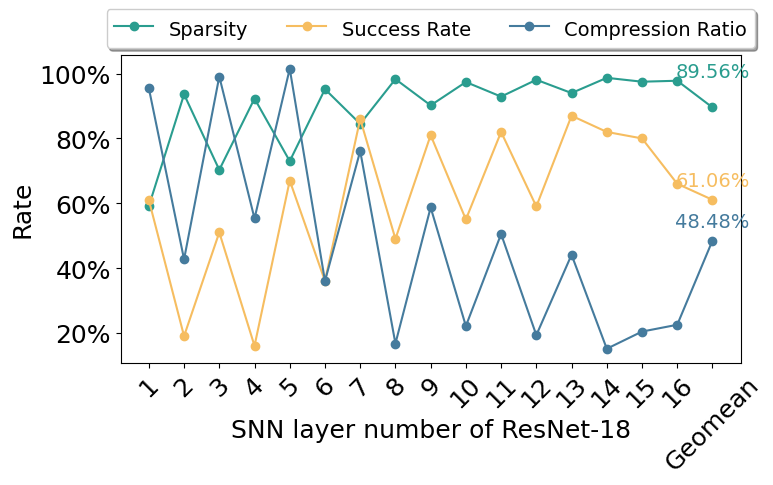

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(ldf['layer'].tolist() + ['Geomean'], ldf['Sparsity'].tolist() + [ldf['Sparsity'].mean()], marker='o', label='Sparsity', color=color_bar2[0])
plt.plot(ldf['layer'].tolist() + ['Geomean'], ldf['successRate'].tolist() + [ldf['successRate'].mean()], marker='o', label='Success Rate', color=color_bar2[1])
plt.plot(ldf['layer'].tolist() + ['Geomean'], ldf['Compression ratio'].tolist() + [ldf['Compression ratio'].mean()], marker='o', label='Compression Ratio', color=color_bar2[2])
plt.xticks(rotation=45)
plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.50, 1.18),
                 fancybox=True, shadow=True, ncol=3, labelspacing=0.4, handleheight=1.5)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.annotate(f"{ldf['Sparsity'].mean() * 100:.2f}%", (len(ldf['layer']), ldf['Sparsity'].mean()+0.05), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color=color_bar2[0])
plt.annotate(f"{ldf['successRate'].mean() * 100:.2f}%", (len(ldf['layer']), ldf['successRate'].mean()), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color=color_bar2[1])
plt.annotate(f"{ldf['Compression ratio'].mean() * 100:.2f}%", (len(ldf['layer']), ldf['Compression ratio'].mean()), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color=color_bar2[2])
plt.ylabel("Rate")
plt.xlabel("SNN layer number of ResNet-18")
ax.xaxis.set_label_coords(.5, -0.18)
plt.savefig('export/layer_rate.pdf', bbox_inches='tight')

## 消融实验

In [24]:
import json
# Speedup Over A100-80GB GPU
gpu_fname = "./gpu_monitor.json"

In [25]:
with open(gpu_fname, 'r') as file:
    gpu_monitor_data = json.load(file)
gpu_energy = max(gpu_monitor_data[0]['energy']) / 100   # gpu进行了100次迭代
gpu_latency = gpu_monitor_data[0]['latency']
print(f"{gpu_energy=} J, {gpu_latency=} s")

gpu_energy=1.7894151999999999 J, gpu_latency=10.11700701713562 s


In [26]:
summary_fname = "./perf_summary.csv"
pd.set_option('display.max_columns', 85)
df = pd.read_csv(summary_fname)
df.sort_values(by=["dyn_stw", "mode", "TW"], ascending=True, inplace=True)
df['dyn_stw'] = df['dyn_stw'].astype(str)
df['speculative'] = df['speculative'].astype(str)
df['csr_compress'] = df['csr_compress'].astype(str)
df['TW'] = df['TW'].astype(str)
df['series'] = df['mode'].str.lower() + '_' + df['TW'] + "_" + df['dyn_stw'].str.lower()

# 将DVS128Gesture的数据替换为DVS128GestureSimplify
filt = (df['dataset'] == 'DVS128Gesture') 
# pd.set_option('display.max_rows', 85)
df = df.loc[~filt]
df['dataset'].replace({'DVS128GestureSimplify': 'DVS128Gesture'}, inplace=True)



In [27]:
# 提取消融实验的结果
ab_filt = (df['dyn_stw'] == 'True')
df_filt = df.loc[ab_filt]
ab_df = df_filt[['dataset', 'speculative', 'csr_compress', 'Total Read Dynamic Energy', 'Total Read Latency']].sort_values(by=['dataset', 'speculative', 'csr_compress'], ascending=True)
ab_df['Total Read Dynamic Energy'] = ab_df['Total Read Dynamic Energy']
ab_df['Total Read Latency'] = ab_df['Total Read Latency']


In [28]:
ab_df['series'] = ab_df['speculative'] + '_' + ab_df['csr_compress']
ab_grp = ab_df.groupby('series')

['False_False', 'False_True', 'True_False', 'True_True']


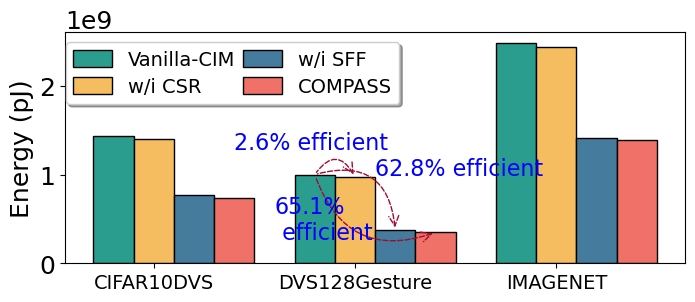

In [29]:
sorted_series = sorted(ab_df['series'].unique(), key=lambda x: [sorted(x.split('_'))])
print(sorted_series)
unique_ds = sorted(ab_df['dataset'].unique())
fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.2
index = np.arange(len(unique_ds))
mode_indexes = []

ckpt_top = defaultdict(list)
lns = []
for idx, series in enumerate(sorted_series):
    res = ab_grp.get_group(series).sort_values(by=['dataset'])
    bottom = np.zeros(len(unique_ds))
    plt.bar(index + (idx -1)*bar_width, height=res['Total Read Dynamic Energy'], width=bar_width, bottom=bottom, label=series, color=color_bar2[idx], edgecolor='black')
    bottom += res['Total Read Dynamic Energy']
    ckpt_top[idx] = bottom.tolist()

# plt.annotate("SSF boosts the energy efficiency", (0.3, 0.8), textcoords="offset points", xytext=(0.5, 96), ha='center', color="#a30b33", fontsize=16)

plt.annotate("", xy=(index[1]-0.5*bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]+0.5*bar_width-0.1, ckpt_top[1][1]), color="#a30b33",
                arrowprops=dict(
        color="#a30b33",
        arrowstyle="<-",
        connectionstyle="arc3,rad=0.8",
        linestyle="--",
        # linewidth=1
    ),
)
plt.annotate(f"{(ckpt_top[0][1]-ckpt_top[1][1])/ckpt_top[0][1]*100:.1f}% efficient", xy=(index[1]-0.5*bar_width+0.1, (ckpt_top[0][1]+ckpt_top[1][1])/2), xytext=(index[1]-0.5*bar_width-0.5, 1.3*(ckpt_top[0][1]+ckpt_top[1][1])/2), color="blue", fontsize=16)

plt.annotate("", xy=(index[1]-0.5*bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]+1.5*bar_width-0.1, ckpt_top[2][1]), color="#a30b33",
                arrowprops=dict(
        color="#a30b33",
        arrowstyle="<-",
        connectionstyle="arc3,rad=0.6",
        linestyle="--",
        # linewidth=1
    ),
)
plt.annotate(f"{(ckpt_top[0][1]-ckpt_top[2][1])/ckpt_top[0][1]*100:.1f}% efficient", xy=(index[1]-0.5*bar_width+0.1, (ckpt_top[2][1]+ckpt_top[0][1])/2), xytext=(index[1]+1.5*bar_width-0.2, 1.45*(ckpt_top[2][1]+ckpt_top[0][1])/2), color="blue", fontsize=16)

plt.annotate("", xy=(index[1]-0.5*bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]+2.5*bar_width-0.1, ckpt_top[3][1]), color="#a30b33",
                arrowprops=dict(
        color="#a30b33",
        arrowstyle="<-",
        connectionstyle="arc3,rad=-0.5",
        linestyle="--",
        # linewidth=1
    ),
)
plt.annotate(f"{(ckpt_top[0][1]-ckpt_top[3][1])/ckpt_top[0][1]*100:.1f}%\n efficient", xy=(index[1]-2.0*bar_width+0.1, 0.4*(ckpt_top[3][1]+ckpt_top[0][1])/2), xytext=(index[1]-2.0*bar_width, 0.4*(ckpt_top[3][1]+ckpt_top[0][1])/2), color="blue", fontsize=16)

plt.legend(['Vanilla-CIM', 'w/i CSR', 'w/i SFF', 'COMPASS'], fontsize=14, loc='upper center', bbox_to_anchor=(0.27, 1.0), fancybox=True, shadow=True, ncol=2, labelspacing=0.4, handleheight=1.0, columnspacing=0.4)
plt.ylabel("Energy (pJ)")
plt.xticks(index, unique_ds, fontsize=14)
plt.savefig('export/ab_energy.pdf', bbox_inches='tight')

['False_False', 'False_True', 'True_False', 'True_True']


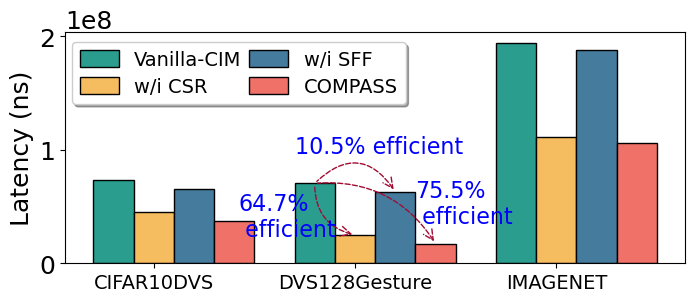

In [30]:
sorted_series = sorted(ab_df['series'].unique(), key=lambda x: [sorted(x.split('_'))])
print(sorted_series)
unique_ds = sorted(ab_df['dataset'].unique())
fig, ax = plt.subplots(figsize=(8, 3))
bar_width = 0.2
index = np.arange(len(unique_ds))
mode_indexes = []

ckpt_top = defaultdict(list)
lns = []
for idx, series in enumerate(sorted_series):
    res = ab_grp.get_group(series).sort_values(by=['dataset'])
    bottom = np.zeros(len(unique_ds))
    plt.bar(index + (idx -1)*bar_width, height=res['Total Read Latency'], width=bar_width, bottom=bottom, label=series, color=color_bar2[idx], edgecolor='black')
    bottom += res['Total Read Latency']
    ckpt_top[idx] = bottom.tolist()

plt.annotate("", xy=(index[1]-0.5*bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]+0.5*bar_width-0.1, ckpt_top[1][1]), color="#a30b33",
                arrowprops=dict(
        color="#a30b33",
        arrowstyle="<-",
        connectionstyle="arc3,rad=-0.4",
        linestyle="--",
        # linewidth=1
    ),
)
plt.annotate(f"{(ckpt_top[0][1]-ckpt_top[1][1])/ckpt_top[0][1]*100:.1f}%\n efficient", xy=(index[1]-0.4*bar_width+0.1, 0.5*(ckpt_top[0][1]+ckpt_top[1][1])/2), xytext=(index[1]-0.4*bar_width-0.5, 0.5*(ckpt_top[0][1]+ckpt_top[1][1])/2), color="blue", fontsize=16)

plt.annotate("", xy=(index[1]-0.5*bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]+1.5*bar_width-0.1, ckpt_top[2][1]), color="#a30b33",
                arrowprops=dict(
        color="#a30b33",
        arrowstyle="<-",
        connectionstyle="arc3,rad=0.6",
        linestyle="--",
        # linewidth=1
    ),
)
plt.annotate(f"{(ckpt_top[0][1]-ckpt_top[2][1])/ckpt_top[0][1]*100:.1f}% efficient", xy=(index[1]-0.5*bar_width+0.1, (ckpt_top[2][1]+ckpt_top[0][1])/2), xytext=(index[1]-0.5*bar_width-0.2, 1.45*(ckpt_top[2][1]+ckpt_top[0][1])/2), color="blue", fontsize=16)

plt.annotate("", xy=(index[1]-0.5*bar_width-0.1, ckpt_top[0][1]), xytext=(index[1]+2.5*bar_width-0.1, ckpt_top[3][1]), color="#a30b33",
                arrowprops=dict(
        color="#a30b33",
        arrowstyle="<-",
        connectionstyle="arc3,rad=0.3",
        linestyle="--",
        # linewidth=1
    ),
)
plt.annotate(f"{(ckpt_top[0][1]-ckpt_top[3][1])/ckpt_top[0][1]*100:.1f}%\n efficient", xy=(index[1]+1.0*bar_width+0.1, 0.4*(ckpt_top[3][1]+ckpt_top[0][1])/2), xytext=(index[1]+1.5*bar_width, 0.8*(ckpt_top[3][1]+ckpt_top[0][1])/2), color="blue", fontsize=16)

plt.legend(['Vanilla-CIM', 'w/i CSR', 'w/i SFF', 'COMPASS'], fontsize=14, loc='upper center', bbox_to_anchor=(0.28, 1.0), fancybox=True, shadow=True, ncol=2, labelspacing=0.4, handleheight=1.0, columnspacing=0.4)
plt.ylabel("Latency (ns)")
plt.xticks(index, unique_ds, fontsize=14)
plt.savefig('export/ab_lat.pdf', bbox_inches='tight')

In [31]:
ab_df.head()

,dataset,speculative,csr_compress,Total Read Dynamic Energy,Total Read Latency,series
29,CIFAR10DVS,False,False,1.440000e+09,73100000.0,False_False
34,CIFAR10DVS,False,True,1.400000e+09,45100000.0,False_True
17,CIFAR10DVS,True,False,7.690000e+08,65900000.0,True_False
59,CIFAR10DVS,True,True,7.390000e+08,37200000.0,True_True
43,DVS128Gesture,False,False,1.000000e+09,70500000.0,False_False


In [32]:
filt = (df['dataset'] == 'CIFAR10DVS')
ab_df = ab_df.loc[filt].sort_values(by=['speculative', 'csr_compress'], ascending=True)
ab_df

,dataset,speculative,csr_compress,Total Read Dynamic Energy,Total Read Latency,series
29,CIFAR10DVS,False,False,1.440000e+09,73100000.0,False_False
34,CIFAR10DVS,False,True,1.400000e+09,45100000.0,False_True
17,CIFAR10DVS,True,False,7.690000e+08,65900000.0,True_False
59,CIFAR10DVS,True,True,7.390000e+08,37200000.0,True_True


In [33]:
energy_speedup = [1] + list(gpu_energy * 1e12 / ab_df['Total Read Dynamic Energy'].values)
latency_speedup = [1] + list(gpu_latency * 1e9 / ab_df['Total Read Latency'].values)
print(f"{energy_speedup=}")
print(f"{latency_speedup=}")

energy_speedup=[1, 1242.6494444444443, 1278.1537142857142, 2326.9378413524055, 2421.4008119079836]
latency_speedup=[1, 138.3995487980249, 224.32388064602262, 153.5205920657909, 271.9625542240758]


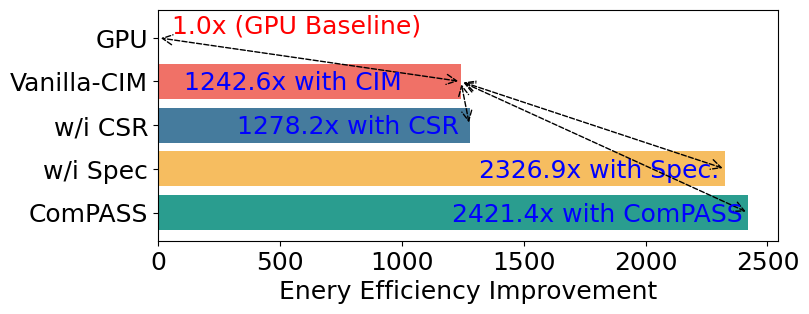

In [34]:
import matplotlib.pyplot as plt

# 创建数据
fig, ax = plt.subplots(figsize=(8, 3))
# 绘制横向条形图
colors = color_bar2[:len(energy_speedup)]
plt.barh(range(len(energy_speedup)), list(reversed(energy_speedup)), color=colors)

# 添加标题和标签
plt.xlabel('Enery Efficiency Improvement')
plt.yticks(range(len(energy_speedup)), ('ComPASS', 'w/i Spec', 'w/i CSR', 'Vanilla-CIM', 'GPU'))
# plt.xscale('log')

plt.annotate(f"{energy_speedup[0]:.1f}x (GPU Baseline)", (energy_speedup[0], 4.1), textcoords="offset points", xytext=(10, 0), ha='left', color='red')
# with CIM
plt.annotate("", xy=(energy_speedup[0], 4), xytext=(energy_speedup[1], 3), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{energy_speedup[1]:.1f}x with CIM", (energy_speedup[1]-300, 2.8), textcoords="offset points", xytext=(10, 0), ha='right', color='blue')

# with CSR
plt.annotate("", xy=(energy_speedup[1], 3), xytext=(energy_speedup[2], 2), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{energy_speedup[2]:.1f}x with CSR", (energy_speedup[2]-100, 1.8), textcoords="offset points", xytext=(10, 0), ha='right', color='blue')

# with Speculative
plt.annotate("", xy=(energy_speedup[1], 3), xytext=(energy_speedup[3], 1), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{energy_speedup[3]:.1f}x with Spec.", (energy_speedup[3]-80, 0.8), textcoords="offset points", xytext=(10, 0), ha='right', color='blue')

# ComPASS
plt.annotate("", xy=(energy_speedup[1], 3), xytext=(energy_speedup[4], 0), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{energy_speedup[4]:.1f}x with ComPASS", (energy_speedup[4]-80, -0.2), textcoords="offset points", xytext=(10, 0), ha='right', color='blue')
plt.savefig('export/energy_speedup.pdf', bbox_inches='tight')


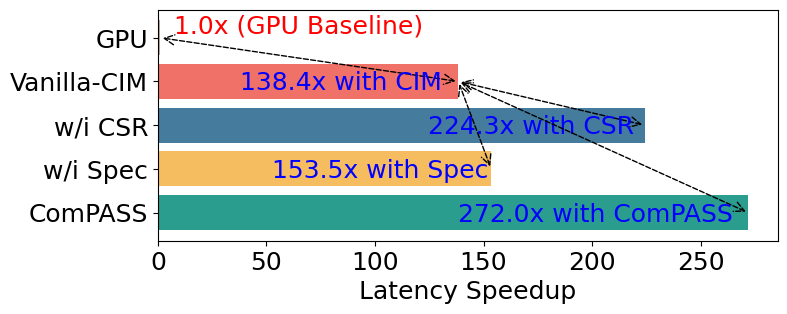

In [35]:
import matplotlib.pyplot as plt

# 创建数据
fig, ax = plt.subplots(figsize=(8, 3))
# 绘制横向条形图
colors = color_bar2[:len(latency_speedup)]
plt.barh(range(len(latency_speedup)), list(reversed(latency_speedup)), color=colors)

# 添加标题和标签
plt.xlabel('Latency Speedup')
plt.yticks(range(len(latency_speedup)), ('ComPASS', 'w/i Spec', 'w/i CSR', 'Vanilla-CIM', 'GPU'))
# plt.xscale('log')

plt.annotate(f"{latency_speedup[0]:.1f}x (GPU Baseline)", (latency_speedup[0], 4.1), textcoords="offset points", xytext=(10, 0), ha='left', color='red')
# with CIM
plt.annotate("", xy=(latency_speedup[0], 4), xytext=(latency_speedup[1], 3), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{latency_speedup[1]:.1f}x with CIM", (0.9*latency_speedup[1], 2.8), textcoords="offset points", xytext=(10, 0), ha='right', color='blue')

# with CSR
plt.annotate("", xy=(latency_speedup[1], 3), xytext=(latency_speedup[2], 2), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{latency_speedup[2]:.1f}x with CSR", (0.95*latency_speedup[2], 1.8), textcoords="offset points", xytext=(10, 0), ha='right', color='b')

# with Speculative
plt.annotate("", xy=(latency_speedup[1], 3), xytext=(latency_speedup[3], 1), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{latency_speedup[3]:.1f}x with Spec", (0.95*latency_speedup[3], 0.8), textcoords="offset points", xytext=(10, 0), ha='right', color='b')

# ComPASS
plt.annotate("", xy=(latency_speedup[1], 3), xytext=(latency_speedup[4], 0), arrowprops=dict(arrowstyle="<->", color='black', linewidth=1, linestyle="--"))
plt.annotate(f"{latency_speedup[4]:.1f}x with ComPASS", (0.95*latency_speedup[4], -0.2), textcoords="offset points", xytext=(10, 0), ha='right', color='b')
plt.savefig('export/latency_speedup.pdf', bbox_inches='tight')